# Загрузка необходимых библиотек

In [7]:
import pandas as pd  # Для работы с данными
import numpy as np  # Для статистических операций
from matplotlib import pyplot as plt  # Для визуализации

from sklearn.ensemble import AdaBoostRegressor, BaggingRegressor
from sklearn.model_selection import RandomizedSearchCV, train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression  # Импорт LinearRegression
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
import seaborn as sns
from sklearn.neighbors import KNeighborsRegressor
from sklearn import model_selection as model_selection

# Importing the dataset from CSV file
df = pd.read_csv('data/countries_pollution_sum.csv')
df.head()

,Entity,Code,Year,"Air pollution (total) (deaths per 100,000)","Indoor air pollution (deaths per 100,000)","Outdoor particulate matter (deaths per 100,000)","Outdoor ozone pollution (deaths per 100,000)",Continent
0,Afghanistan,AFG,1990,302.425941,250.362910,46.446589,5.616442,Asia
1,Afghanistan,AFG,1991,294.212926,242.575125,46.033841,5.603960,Asia
2,Afghanistan,AFG,1992,281.899466,232.043878,44.243766,5.611822,Asia
3,Afghanistan,AFG,1993,281.743548,231.648134,44.440148,5.655266,Asia
4,Afghanistan,AFG,1994,290.150427,238.837177,45.594328,5.718922,Asia


# Определяем незаполненные ячейки

In [8]:
# Определяем незаполненные ячейки
df.isna().sum()

Entity                                                0
Code                                                980
Year                                                  0
Air pollution (total) (deaths per 100,000)            0
Indoor air pollution (deaths per 100,000)             0
Outdoor particulate matter (deaths per 100,000)       0
Outdoor ozone pollution (deaths per 100,000)          0
Continent                                          1260
dtype: int64

# Удаление пустых строк

In [21]:
# Копируем оригинальный датасет
countries = df.copy(deep=True)
# Удаляем пустые строки
countries.dropna(inplace=True)
# Определяем незаполненные ячейки
countries.isna().sum()

Entity                                             0
Code                                               0
Year                                               0
Air pollution (total) (deaths per 100,000)         0
Indoor air pollution (deaths per 100,000)          0
Outdoor particulate matter (deaths per 100,000)    0
Outdoor ozone pollution (deaths per 100,000)       0
Continent                                          0
dtype: int64

#  Визуализация 
Представление общей смертности от загрязнений и по видам загрязнений

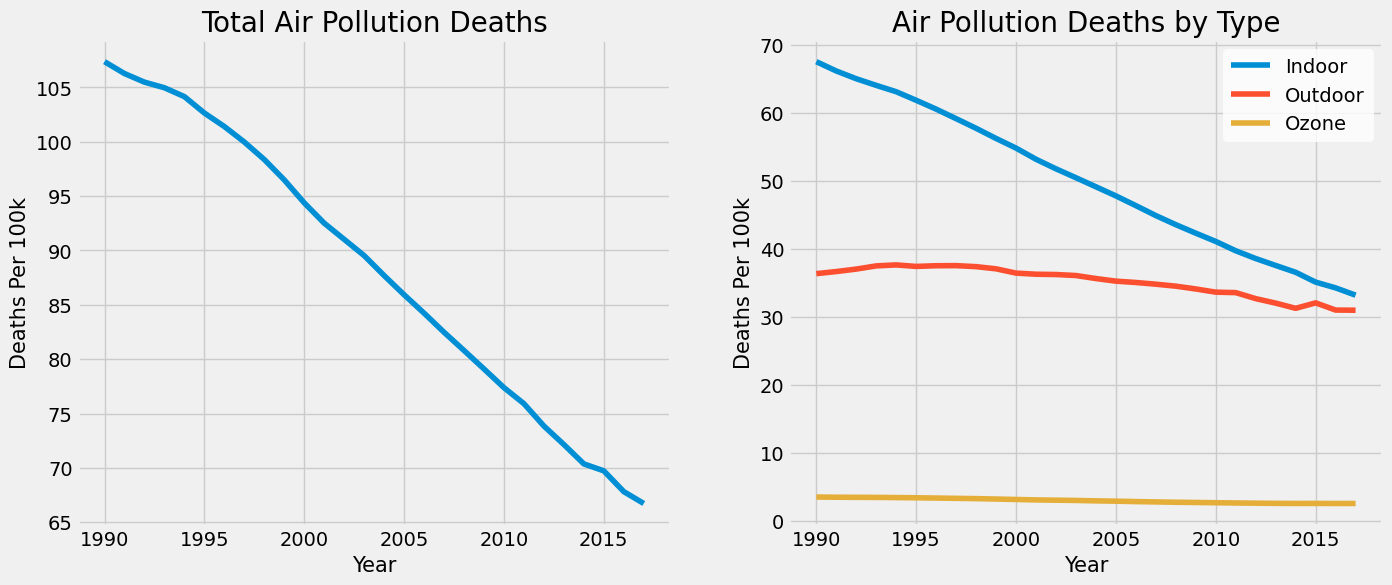

In [11]:
plt.figure(figsize=(15,6))  # Создаём участок

plt.subplot(1,2,1)  # Specifiying which subplot this will be
plt.plot(countries.groupby('Year')['Air pollution (total) (deaths per 100,000)'].mean())  # Creating the plot
plt.xlabel('Year', size=15)  # Labeling the x-axis
plt.ylabel('Deaths Per 100k', size=15)  # Labeling the y-axis
plt.title('Total Air Pollution Deaths', size=20, fontfamily='sans-serif')  # Adding a title
plt.style.use('fivethirtyeight')  # Using a plot style to include gridlines

plt.subplot(1,2,2)  # Specifying which subplot this will be
plt.plot(countries.groupby('Year')['Indoor air pollution (deaths per 100,000)'].mean(), label='Indoor')  # Adding a line for indoor deaths
plt.plot(countries.groupby('Year')['Outdoor particulate matter (deaths per 100,000)'].mean(), label='Outdoor')  # Adding a line for outdoor deaths
plt.plot(countries.groupby('Year')['Outdoor ozone pollution (deaths per 100,000)'].mean(), label='Ozone')  # Adding a line for ozone deaths
plt.xlabel('Year', size=15)  # Labeling the x-axis
plt.ylabel('Deaths Per 100k', size=15)  # Labeling the y-axis
plt.title('Air Pollution Deaths by Type', size=20, fontfamily='sans-serif')  # Adding a title
legend = plt.legend(frameon=1, loc='best')  # Adding the legend and assigning it to a variable
frame = legend.get_frame()  # Assigning the legend's frame to a variable
frame.set_color('white')  # Setting the background color of the legend
plt.style.use('fivethirtyeight')  # Using a plot style to include gridlines

Оценим ситуацию в нескольких отдельных странах c помощью линейной регрессии

In [30]:
lr_model = LinearRegression()  # Creating the linear regression model instance
lr_slopes = []  # Clearing the slopes list 
lr_intercepts = []  # Clearing the intercepts list
lr_scores = []  # Clearing the scores list

# Using a loop to train and test every country
for c in countries['Entity'].unique():
    X = countries[countries['Entity'] == c].iloc[:,2].values.reshape(-1,1)  # Assigning years to the 'X' variable
    y = countries[countries['Entity'] == c].iloc[:,3].values.reshape(-1,1)  # Assigning deaths to the 'y' variable
    lr_model.fit(X, y)  # Training the model
    lr_slopes.append(round(lr_model.coef_[0][0], 2))  # Adding slope to the list
    lr_intercepts.append(round(lr_model.intercept_[0], 2))  # Adding intercept to the list
    lr_scores.append(round(lr_model.score(X, y), 2))  # Adding score to the list

# Converting the lists to a dataframe
lr_countries = pd.DataFrame({'Country': countries['Entity'].unique(), 
                      'Slope': lr_slopes, 'Intercept': lr_intercepts, 'Score': lr_scores})
# Creating a new datafram of only the countries showing a positive slope
# increasing_countries = lr_countries[lr_countries['Slope'] > 0].reset_index(drop=True)
# increasing_countries
df_countries = lr_countries.sort_values(by='Slope', ascending=False).reset_index(drop=True)
df_countries.head()

,Country,Slope,Intercept,Score
0,Zimbabwe,1.93,-3730.13,0.39
1,Lesotho,1.50,-2852.13,0.52
2,Philippines,0.37,-637.24,0.22
3,Libya,0.13,-200.40,0.19
4,Uzbekistan,0.06,-8.53,0.00



Мы определили пять стран, которые демонстрируют положительный наклон и, следовательно, растущий уровень смертности из-за загрязнения воздуха. Однако оценки этих моделей снова очень низкие, поэтому нам следует визуализировать данные по странам, чтобы определить, насколько они точны.

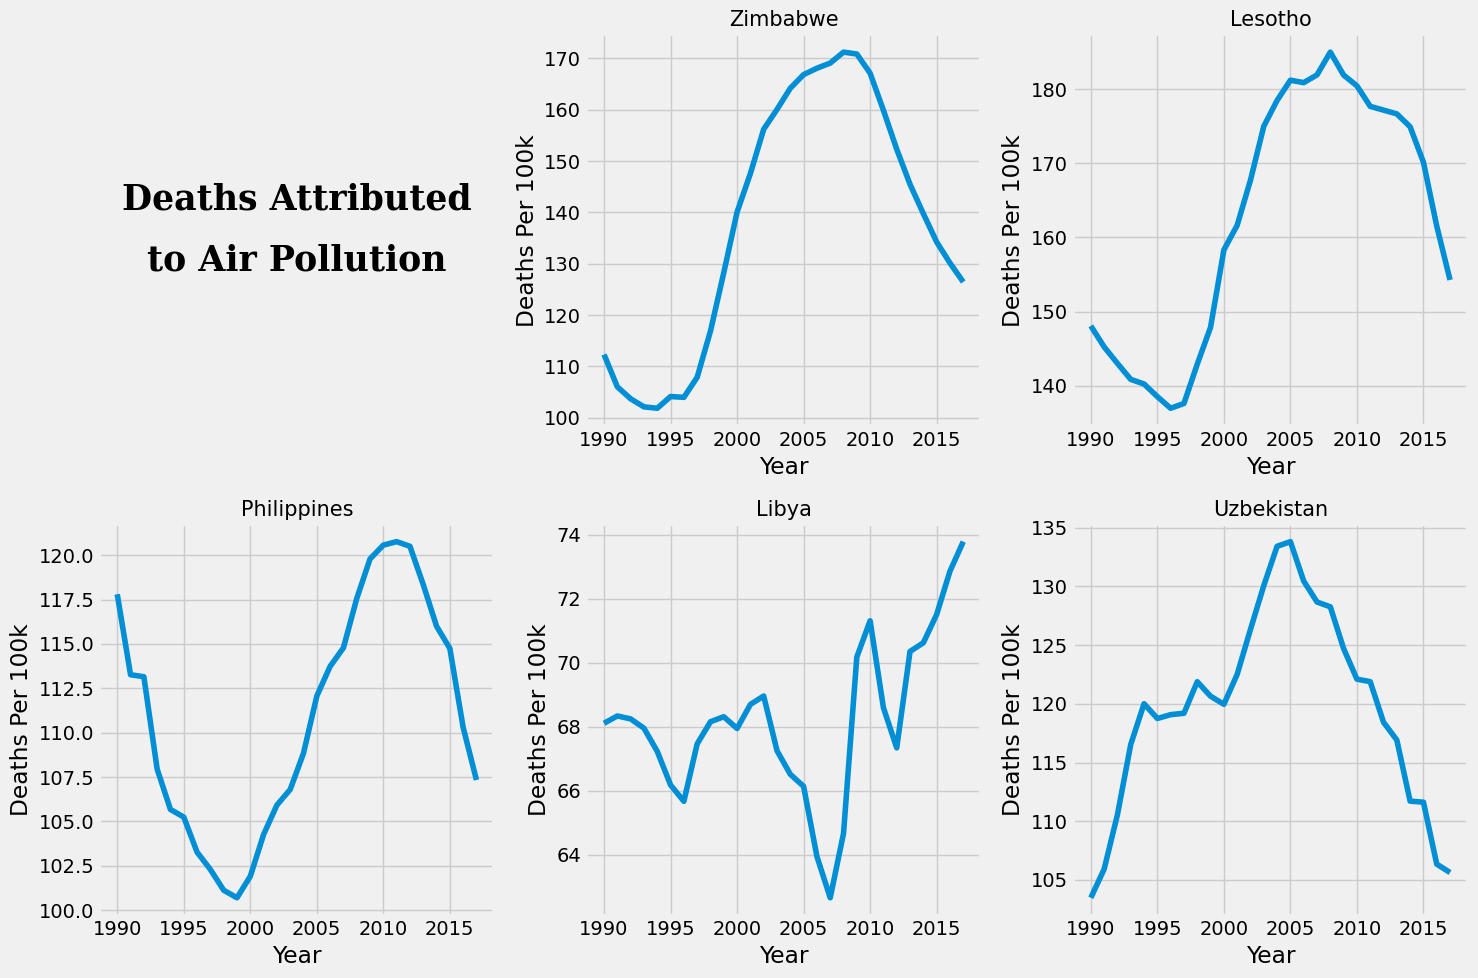

In [31]:
growing_countries = df_countries.head()

plt.figure(figsize=(15,10))  # Increasing the plot size

# Using a loop to add each country's subplot
for i in range(len(growing_countries)):
    plt.subplot(2,3,i+2)  # Specifying where to place the subplot
    # Pulling the country's data from the 'countries' dataframe
    plt.plot(countries[countries['Entity'] == growing_countries.iloc[i][0]].iloc[:,2],
             countries[countries['Entity'] == growing_countries.iloc[i][0]].iloc[:,3])
    plt.xlabel('Year')  # Labeling the x-axis
    plt.ylabel('Deaths Per 100k')  # Labeling the y-axis
    plt.title(growing_countries.iloc[i][0], size=15)  # Adding a title

# Adding an overall title to the first subplot
plt.subplot(2,3,1)  # Specifying where to place the subplot
plt.axis('off')  # Disabling the title subplot's axes
plt.text(0.5, 0.5, 'Deaths Attributed\nto Air Pollution', size=25, ha='center', va='center',
        linespacing=2, fontfamily='serif', fontweight='bold')  # Adding and formatting the title
plt.style.use('fivethirtyeight')  # Using a plot style to include gridlines
plt.tight_layout()  # Specifying a layout to prevent overlapping subplot labels

Исходя из приведенных графиков видно, что данные по смертности этих стран от загрязнения воздуха имеют линейной зависимости. Что с отрицательной стороны говорит о их качестве. И, не смотря на это, даже здесь просматривается тенденция на улучшение ситуации. Исключение лишь составляет Libya, где смертность рфстёт, хот и с рваным графиком.

Сделаем выпорку по странам в середине списка и средними показателями относительно мировых.

In [58]:
middle_rows = df_countries.iloc[len(df_countries)//2 - 2:len(df_countries)//2 + 3]
middle_rows

,Country,Slope,Intercept,Score
91,Ireland,-1.23,2489.45,0.98
92,Ukraine,-1.25,2589.19,0.71
93,Kenya,-1.26,2647.12,0.86
94,Singapore,-1.26,2558.16,0.99
95,Colombia,-1.28,2610.93,0.98


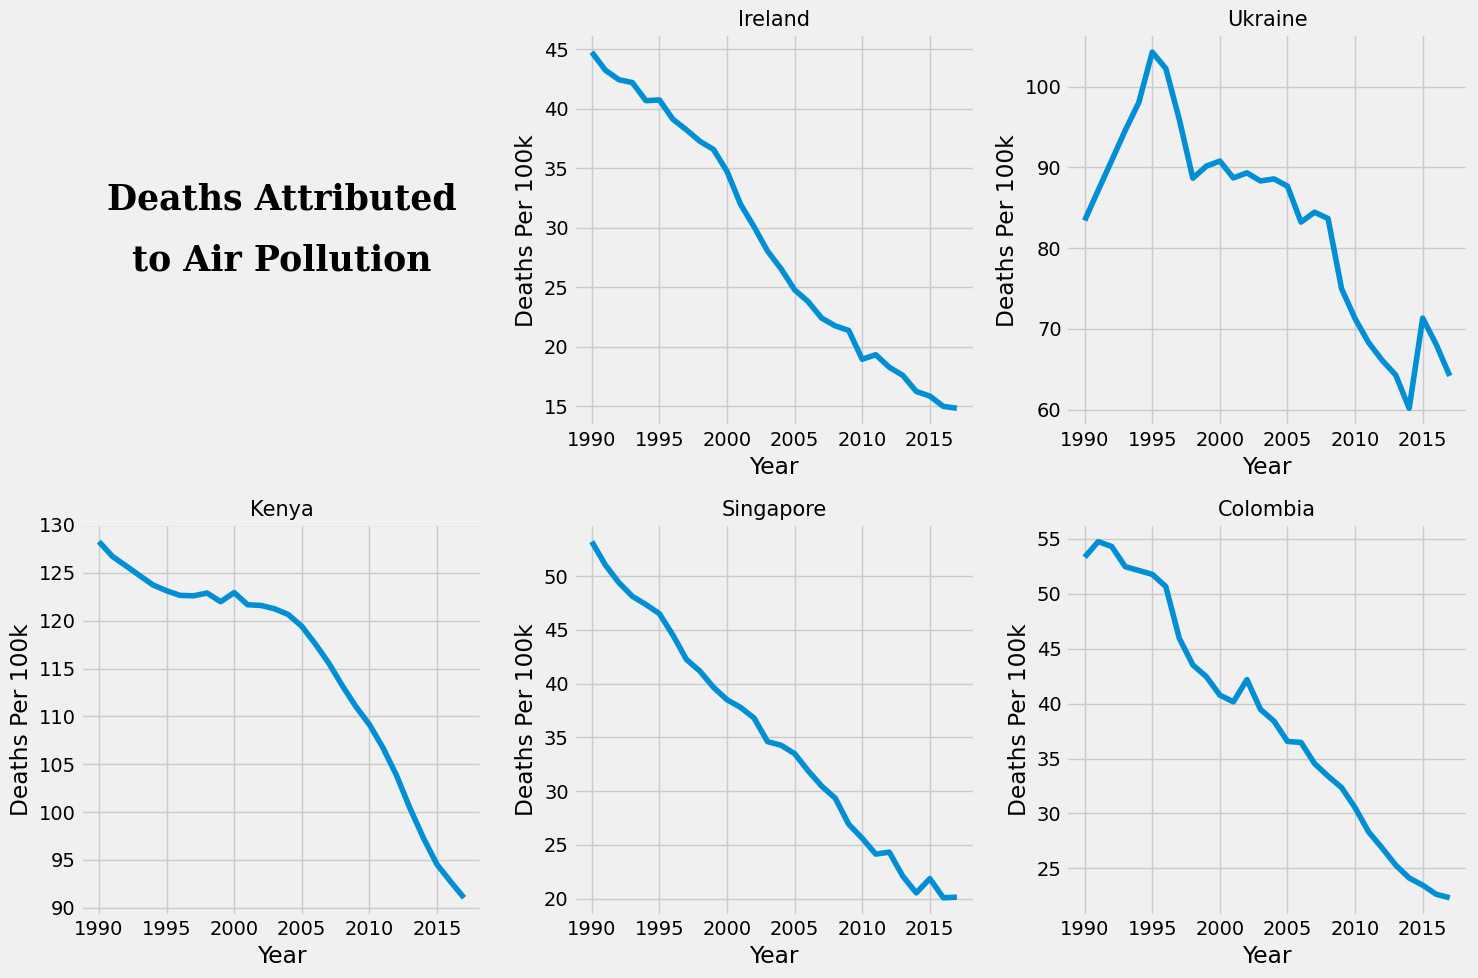

In [57]:
growing_countries = middle_rows.tail(6)

plt.figure(figsize=(15,10))  # Increasing the plot size

# Using a loop to add each country's subplot
for i in range(len(growing_countries)):
    plt.subplot(2,3,i+2)  # Specifying where to place the subplot
    # Pulling the country's data from the 'countries' dataframe
    plt.plot(countries[countries['Entity'] == growing_countries.iloc[i][0]].iloc[:,2],
             countries[countries['Entity'] == growing_countries.iloc[i][0]].iloc[:,3])
    plt.xlabel('Year')  # Labeling the x-axis
    plt.ylabel('Deaths Per 100k')  # Labeling the y-axis
    plt.title(growing_countries.iloc[i][0], size=15)  # Adding a title

# Adding an overall title to the first subplot
plt.subplot(2,3,1)  # Specifying where to place the subplot
plt.axis('off')  # Disabling the title subplot's axes
plt.text(0.5, 0.5, 'Deaths Attributed\nto Air Pollution', size=25, ha='center', va='center',
        linespacing=2, fontfamily='serif', fontweight='bold')  # Adding and formatting the title
plt.style.use('fivethirtyeight')  # Using a plot style to include gridlines
plt.tight_layout()  # Specifying a layout to prevent overlapping subplot labels

В данных странах идет очевидное снижение смертности с каждым годом. Выделяется на общем фоне Ukraine с резкими перепадами, но всё же тенденция идет на снижение.

Приведем ещё один пример. Из числа тех стран, что в лидерах по снижению смертности от загрязнения воздуха.

In [46]:
df_countries.tail(6)

,Country,Slope,Intercept,Score
180,China,-4.81,9758.27,0.98
181,Maldives,-4.92,9918.81,0.96
182,Angola,-5.53,11249.90,0.99
183,Laos,-5.89,11988.71,1.00
184,Rwanda,-6.67,13532.06,0.92
185,Equatorial Guinea,-7.66,15502.92,0.91


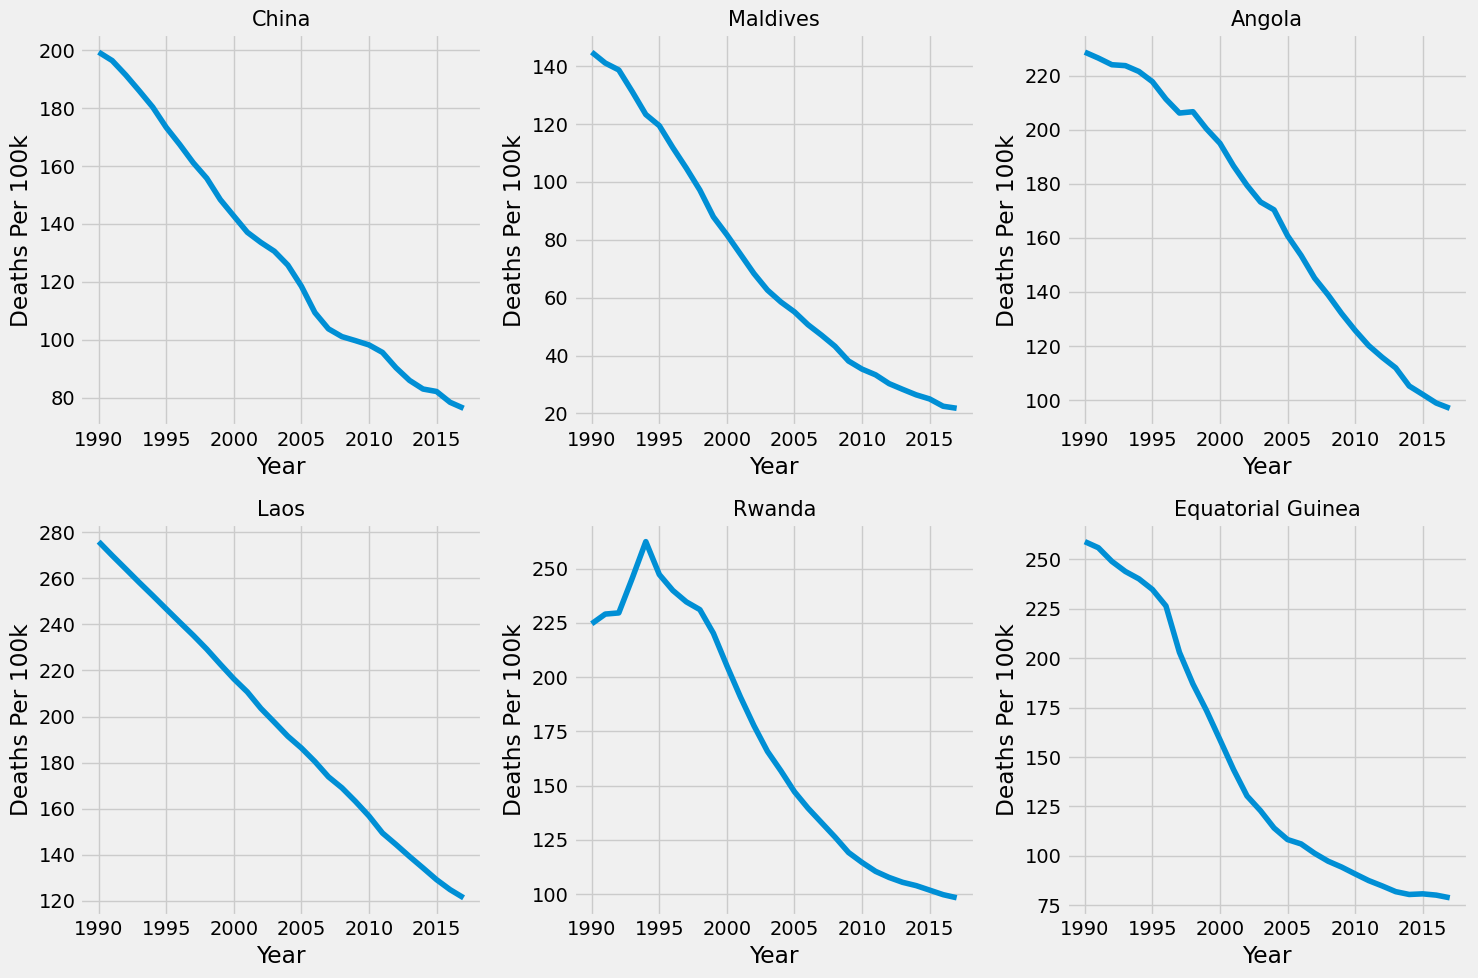

In [60]:
growing_countries = df_countries.tail(6)

plt.figure(figsize=(15,10))  # Increasing the plot size

# Using a loop to add each country's subplot
for i in range(len(growing_countries)):
    plt.subplot(2,3,i+1)  # Specifying where to place the subplot
    # Pulling the country's data from the 'countries' dataframe
    plt.plot(countries[countries['Entity'] == growing_countries.iloc[i][0]].iloc[:,2],
             countries[countries['Entity'] == growing_countries.iloc[i][0]].iloc[:,3])
    plt.xlabel('Year')  # Labeling the x-axis
    plt.ylabel('Deaths Per 100k')  # Labeling the y-axis
    plt.title(growing_countries.iloc[i][0], size=15)  # Adding a title

# Adding an overall title to the first subplot
# plt.subplot(2,3,1)  # Specifying where to place the subplot
# plt.axis('off')  # Disabling the title subplot's axes
# plt.text(0.5, 0.5, 'Deaths Attributed\nto Air Pollution', size=25, ha='center', va='center',
#         linespacing=2, fontfamily='serif', fontweight='bold')  # Adding and formatting the title
plt.style.use('fivethirtyeight')  # Using a plot style to include gridlines
plt.tight_layout()  # Specifying a layout to prevent overlapping subplot labels

Наюлюдается аналогичная ситуация со снижением смертности, что не удивительно для лидирующих стран.

В качестве последнего упражнения в машинном обучении мы используем линейную регрессию общего числа смертей во всем мире, чтобы делать прогнозы на будущее.

In [16]:
# Assigning years to the 'X' variable and total deaths to the 'y' variable for convenience
X = countries['Year'].unique().reshape(-1,1)
y = countries.groupby('Year')['Air pollution (total) (deaths per 100,000)'].mean().values

# Calculating the index to split the data into train (80%) and test (20%) sets
split_i = int(len(y)*0.8) + 1

# Splitting the data into train and test sets
X_train = X[:split_i]
X_test = X[split_i:]
y_train = y[:split_i]
y_test = y[split_i:]

# Fitting a linear regression model on our train set
lr_model.fit(X_train, y_train)

# Calculating and displaying the model's score (R-square) against our test set
round(lr_model.score(X_test, y_test), 2)

0.83

Модель показывает относительно приличный результат - 0,83. Мы можем визуализировать это соответствие ниже.

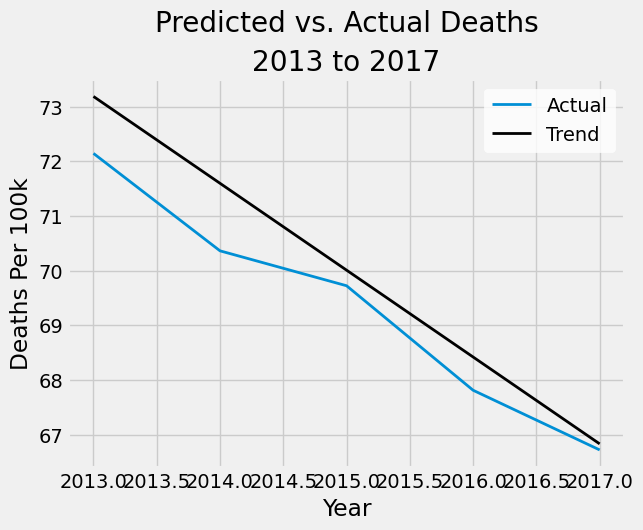

In [17]:
# Using our model to predict y-values from our test set's x-values
y_pred = lr_model.predict(X_test)

plt.plot(X_test, y_test, label='Actual', linewidth=2)  # Adding the actual deaths data to the plot
plt.plot(X_test, y_pred, label='Trend', c='black', linewidth=2)  # Adding the predicted deaths trendline to the plot
plt.title('Predicted vs. Actual Deaths\n2013 to 2017', linespacing=1.5,
         fontfamily='sans-serif')  # Adding a title
plt.xlabel('Year')  # Labeling the x-axis
plt.ylabel('Deaths Per 100k')  # Labeling the y-axis
legend = plt.legend(frameon=1, loc='best')  # Adding the legend and assigning it to a variable
frame = legend.get_frame()  # Assigning the legend's frame to a variable
frame.set_color('white')  # Setting the background color of the legend

Зная, как работает модель линейной регрессии, мы теперь подогоним ее, используя весь нерасщепленный набор данных, и сделаем прогнозы на будущее ("будущим" в данном случае является 2018 год и последующий период).

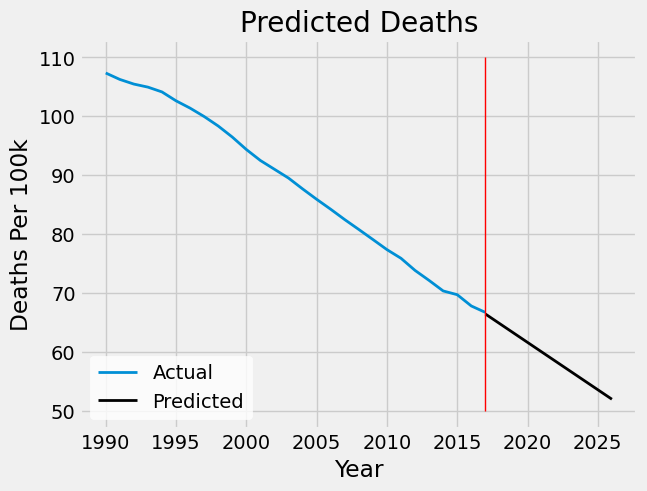

In [18]:
# Fitting the model on the entire dataset
lr_model.fit(X, y)

# Defining our x-values for the future
X_future = np.array(range(2017,2069)).reshape(-1,1)

# Predicting 50 years into the future
y_pred = lr_model.predict(X_future)

# Converting the predictions into a dataframe
pred_df = pd.DataFrame(list(zip([x[0] for x in X_future], y_pred)), columns = ['Year', 'Prediction'])

# Plotting existing data with predictinos for the next 10 years
plt.plot(X, y, label='Actual', linewidth=2)  # Adding line for the actual deaths
plt.plot(pred_df['Year'].iloc[:10,], pred_df['Prediction'].iloc[:10,],
         c='black', label='Predicted', linewidth=2)  # Adding line for the predicted deaths
plt.vlines(x=2017, ymin=50, ymax=110, color='red', linewidths = 1)  # Adding vertical line marking the present
plt.xlabel('Year')  # Labeling the x-axis
plt.ylabel('Deaths Per 100k')  # Labeling the y-axis
plt.title('Predicted Deaths', fontfamily='sans-serif')  # Adding a title
plt.legend(loc='lower left')  # Adding the legend
plt.style.use('fivethirtyeight')  # Using a plot style to include gridlines
legend = plt.legend(frameon=1, loc='lower left')  # Adding the legend and assigning it to a variable
frame = legend.get_frame()  # Assigning the legend's frame to a variable
frame.set_color('white')  # Setting the background color of the legend

## Для России с поиощью LinearRegression
Спрогнозируем смертность от загрязнения для России.

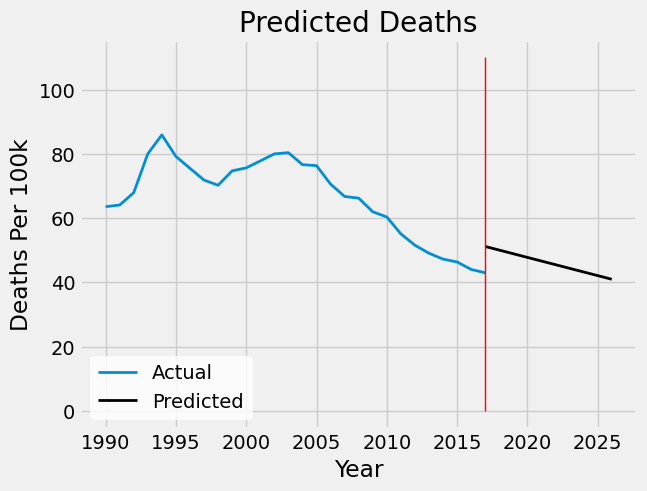

In [20]:
russia_df = countries[countries['Entity'] == 'Russia']
X = russia_df['Year'].array.reshape(-1,1)
y = russia_df['Air pollution (total) (deaths per 100,000)'].values

# coent_ries = countries[countries['Year'] >= 2005]
# count_ae = coent_ries[coent_ries['Entity'] == 'Russia']
# X = count_ae['Year'].array.reshape(-1,1)
# y = count_ae['Air pollution (total) (deaths per 100,000)'].values

# Fitting the model on the entire dataset
lr_model.fit(X, y)

# Defining our x-values for the future
X_future = np.array(range(2017,2069)).reshape(-1,1)

# Predicting 50 years into the future
y_pred = lr_model.predict(X_future)

# Converting the predictions into a dataframe
pred_df = pd.DataFrame(list(zip([x[0] for x in X_future], y_pred)), columns = ['Year', 'Prediction'])

# Plotting existing data with predictinos for the next 10 years
plt.plot(X, y, label='Actual', linewidth=2)  # Adding line for the actual deaths
plt.plot(pred_df['Year'].iloc[:10,], pred_df['Prediction'].iloc[:10,],
         c='black', label='Predicted', linewidth=2)  # Adding line for the predicted deaths
plt.vlines(x=2017, ymin=0, ymax=110, color='red', linewidths = 1)  # Adding vertical line marking the present
plt.xlabel('Year')  # Labeling the x-axis
plt.ylabel('Deaths Per 100k')  # Labeling the y-axis
plt.title('Predicted Deaths', fontfamily='sans-serif')  # Adding a title
plt.legend(loc='lower left')  # Adding the legend
plt.style.use('fivethirtyeight')  # Using a plot style to include gridlines
legend = plt.legend(frameon=1, loc='lower left')  # Adding the legend and assigning it to a variable
frame = legend.get_frame()  # Assigning the legend's frame to a variable
frame.set_color('white')  # Setting the background color of the legend

## Предсказание с помощью XGBRegressor для России

In [147]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

# Загрузка набора данных Wine Quality из CSV-файла в DataFrame
# df = pd.read_csv("datasets/WineQT.csv")
# df
# # Определение признаков (X) и целевой переменной (y)
# X = df.drop(columns=['quality'])
# y = df['quality']

russia_df = countries[countries['Entity'] == 'Russia']
X = russia_df['Year'].array.reshape(-1,1)
y = russia_df['Air pollution (total) (deaths per 100,000)']

# Нормализация признаков с помощью StandardScaler
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

# Разделение данных на обучающий и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Создание модели XGBoost для регрессии
xgb = XGBRegressor()

# Определение сетки параметров для перебора (max_depth, learning_rate и т.д., можно добавить другие параметры)
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300]
}

# Использование GridSearchCV для поиска наилучших параметров модели
grid_search = GridSearchCV(xgb, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Вывод наилучших параметров и оценки на кросс-валидации
print("Наилучшие параметры на кросс-валидации:", grid_search.best_params_)
print("Наилучшая оценка на кросс-валидации:", grid_search.best_score_)

# Прогнозирование на тестовом наборе с помощью модели с оптимальными параметрами
y_pred = grid_search.predict(X_test)

# Вычисление среднеквадратической ошибки (MSE) на тестовом наборе
mse = mean_squared_error(y_pred, y_test)

# Вывод значения MSE
print("MSE на тестовом наборе: ", mse)

Наилучшие параметры на кросс-валидации: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 300}
Наилучшая оценка на кросс-валидации: -38.04029367465567
MSE на тестовом наборе:  10.117051764697555


Наилучшие параметры на кросс-валидации: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 300}
Наилучшая оценка на кросс-валидации: -52.62807114121692


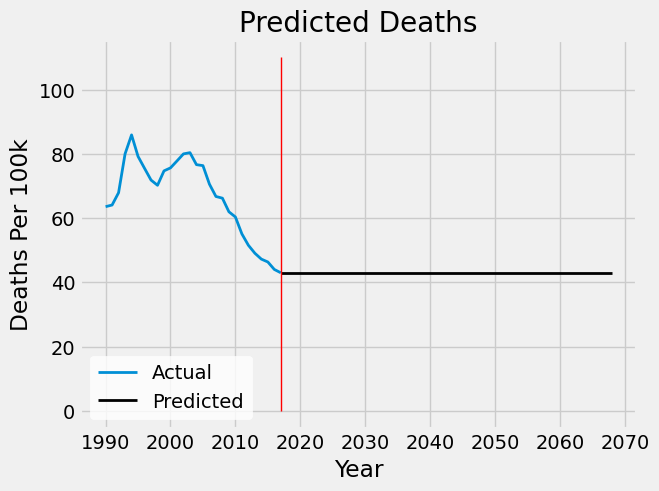

In [149]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

russia_df = countries[countries['Entity'] == 'Russia']
X = russia_df['Year'].array.reshape(-1,1)
y = russia_df['Air pollution (total) (deaths per 100,000)']

# Нормализация признаков с помощью StandardScaler
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

# # Разделение данных на обучающий и тестовый наборы
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Создание модели XGBoost для регрессии
xgb = XGBRegressor()

# Определение сетки параметров для перебора (max_depth, learning_rate и т.д., можно добавить другие параметры)
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300]
}

# Использование GridSearchCV для поиска наилучших параметров модели
grid_search = GridSearchCV(xgb, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X, y)

# Вывод наилучших параметров и оценки на кросс-валидации
print("Наилучшие параметры на кросс-валидации:", grid_search.best_params_)
print("Наилучшая оценка на кросс-валидации:", grid_search.best_score_)

# Defining our x-values for the future
X_future = np.array(range(2017,2069)).reshape(-1,1)

# Predicting 50 years into the future
y_pred = grid_search.predict(X_future)

# Converting the predictions into a dataframe
pred_df = pd.DataFrame(list(zip([x[0] for x in X_future], y_pred)), columns = ['Year', 'Prediction'])
# Plotting existing data with predictinos for the next 10 years
plt.plot(X, y, label='Actual', linewidth=2)  # Adding line for the actual deaths
plt.plot(pred_df['Year'].iloc[:69,], pred_df['Prediction'].iloc[:69,],
         c='black', label='Predicted', linewidth=2)  # Adding line for the predicted deaths
plt.vlines(x=2017, ymin=0, ymax=110, color='red', linewidths = 1)  # Adding vertical line marking the present
plt.xlabel('Year')  # Labeling the x-axis
plt.ylabel('Deaths Per 100k')  # Labeling the y-axis
plt.title('Predicted Deaths', fontfamily='sans-serif')  # Adding a title
plt.legend(loc='lower left')  # Adding the legend
plt.style.use('fivethirtyeight')  # Using a plot style to include gridlines
legend = plt.legend(frameon=1, loc='lower left')  # Adding the legend and assigning it to a variable
frame = legend.get_frame()  # Assigning the legend's frame to a variable
frame.set_color('white')  # Setting the background color of the legend

# KNN for Russia

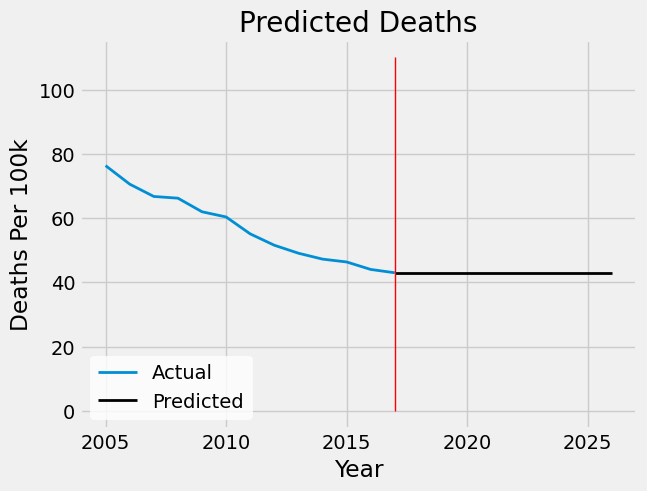

In [170]:
# Необходимые библиотеки


russia_df = countries[countries['Entity'] == 'Russia']
russia_df = russia_df[russia_df['Year'] >= 2005]
X = russia_df['Year'].array.reshape(-1,1)
y = russia_df['Air pollution (total) (deaths per 100,000)'].values

# Определение значений параметров для подбора
param_grid = {'n_neighbors': range(1, 8)}

# Создание модели k-NN
knn = KNeighborsRegressor(metric='minkowski', p=2)

# Создание объекта GridSearchCV для подбора параметра k
grid = model_selection.GridSearchCV(knn, param_grid, cv=5)

# Обучение модели на тренировочных данных
grid.fit(X, y)

# Определение лучшего значения k
best_k = grid.best_params_['n_neighbors']

# Defining our x-values for the future
X_future = np.array(range(2017,2069)).reshape(-1,1)

# Predicting 50 years into the future
y_pred = grid.predict(X_future)

# Converting the predictions into a dataframe
pred_df = pd.DataFrame(list(zip([x[0] for x in X_future], y_pred)), columns = ['Year', 'Prediction'])
# Plotting existing data with predictinos for the next 10 years
plt.plot(X, y, label='Actual', linewidth=2)  # Adding line for the actual deaths
plt.plot(pred_df['Year'].iloc[:10,], pred_df['Prediction'].iloc[:10,],
         c='black', label='Predicted', linewidth=2)  # Adding line for the predicted deaths
plt.vlines(x=2017, ymin=0, ymax=110, color='red', linewidths = 1)  # Adding vertical line marking the present
plt.xlabel('Year')  # Labeling the x-axis
plt.ylabel('Deaths Per 100k')  # Labeling the y-axis
plt.title('Predicted Deaths', fontfamily='sans-serif')  # Adding a title
plt.legend(loc='lower left')  # Adding the legend
plt.style.use('fivethirtyeight')  # Using a plot style to include gridlines
legend = plt.legend(frameon=1, loc='lower left')  # Adding the legend and assigning it to a variable
frame = legend.get_frame()  # Assigning the legend's frame to a variable
frame.set_color('white')  # Setting the background color of the legend


# Линейная регрессия for Russia

In [144]:
# Импорт необходимых библиотек
import numpy as np
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression  # Импорт LinearRegression
from sklearn.metrics import mean_squared_error

russia_df = countries[countries['Entity'] == 'Russia']
russia_df = russia_df[russia_df['Year'] >= 2005]
X = russia_df['Year'].array.reshape(-1,1)
y = russia_df['Air pollution (total) (deaths per 100,000)'].values

# Нормализация признаков с помощью StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Разделение данных на обучающий и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Создание модели LinearRegression для регрессии
lin_reg = LinearRegression()

# Обучение модели на обучающем наборе данных
lin_reg.fit(X_train, y_train)

# Прогнозирование на тестовом наборе с помощью модели
y_pred = lin_reg.predict(X_test)

# Вычисление среднеквадратической ошибки (MSE) на тестовом наборе
mse = mean_squared_error(y_pred, y_test)

# Вывод значения MSE
print("MSE на тестовом наборе: ", mse)

MSE на тестовом наборе:  5.823983290132754


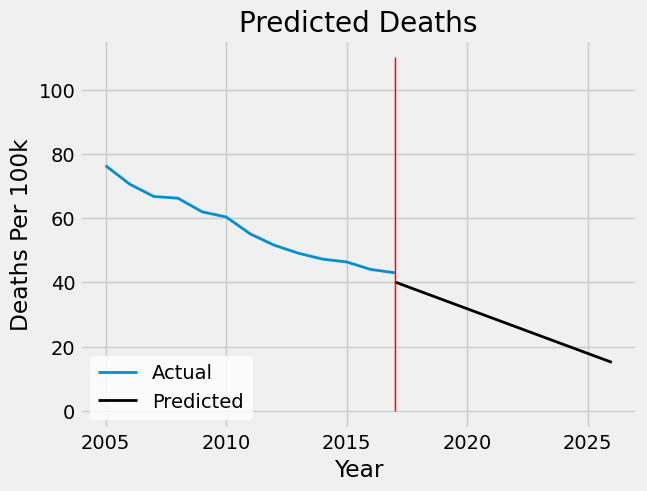

In [8]:
russia_df = countries[countries['Entity'] == 'Russia']
russia_df = russia_df[russia_df['Year'] >= 2005]
X = russia_df['Year'].array.reshape(-1,1)
y = russia_df['Air pollution (total) (deaths per 100,000)'].values

# Создание модели LinearRegression для регрессии
lin_reg = LinearRegression()

# Обучение модели на обучающем наборе данных
lin_reg.fit(X, y)

# Defining our x-values for the future
X_future = np.array(range(2017,2069)).reshape(-1,1)

# Predicting 50 years into the future
y_pred = lin_reg.predict(X_future)

# Converting the predictions into a dataframe
pred_df = pd.DataFrame(list(zip([x[0] for x in X_future], y_pred)), columns = ['Year', 'Prediction'])
# Plotting existing data with predictinos for the next 10 years
plt.plot(X, y, label='Actual', linewidth=2)  # Adding line for the actual deaths
plt.plot(pred_df['Year'].iloc[:10,], pred_df['Prediction'].iloc[:10,],
         c='black', label='Predicted', linewidth=2)  # Adding line for the predicted deaths
plt.vlines(x=2017, ymin=0, ymax=110, color='red', linewidths = 1)  # Adding vertical line marking the present
plt.xlabel('Year')  # Labeling the x-axis
plt.ylabel('Deaths Per 100k')  # Labeling the y-axis
plt.title('Predicted Deaths', fontfamily='sans-serif')  # Adding a title
plt.legend(loc='lower left')  # Adding the legend
plt.style.use('fivethirtyeight')  # Using a plot style to include gridlines
legend = plt.legend(frameon=1, loc='lower left')  # Adding the legend and assigning it to a variable
frame = legend.get_frame()  # Assigning the legend's frame to a variable
frame.set_color('white')  # Setting the background color of the legend

## Повышение производительности линейной регрессии
Мы можем использовать технику Boosting для оптимизации количества моделей (мы можем использовать простой поиск по сетке, поскольку у нас есть единственный гиперпараметр).

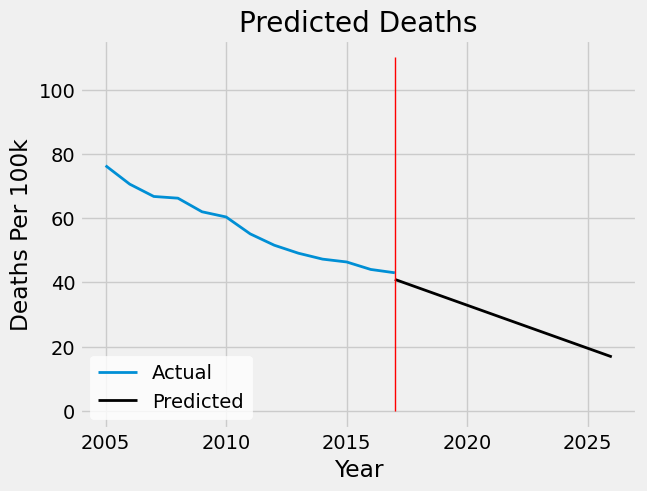

In [4]:
russia_df = countries[countries['Entity'] == 'Russia']
russia_df = russia_df[russia_df['Year'] >= 2005]
X = russia_df['Year'].array.reshape(-1,1)
y = russia_df['Air pollution (total) (deaths per 100,000)'].values

lr_boost = GridSearchCV(AdaBoostRegressor(LinearRegression()),
param_grid =  {
               'n_estimators':np.arange(20,500,5)
      },
      cv=5, 
      refit=True,
      scoring="neg_mean_absolute_error")

lr_boost.fit(X ,y)

# Defining our x-values for the future
X_future = np.array(range(2017,2069)).reshape(-1,1)

# Predicting 50 years into the future
y_pred = lr_boost.predict(X_future)

# Converting the predictions into a dataframe
pred_df = pd.DataFrame(list(zip([x[0] for x in X_future], y_pred)), columns = ['Year', 'Prediction'])
# Plotting existing data with predictinos for the next 10 years
plt.plot(X, y, label='Actual', linewidth=2)  # Adding line for the actual deaths
plt.plot(pred_df['Year'].iloc[:10,], pred_df['Prediction'].iloc[:10,],
         c='black', label='Predicted', linewidth=2)  # Adding line for the predicted deaths
plt.vlines(x=2017, ymin=0, ymax=110, color='red', linewidths = 1)  # Adding vertical line marking the present
plt.xlabel('Year')  # Labeling the x-axis
plt.ylabel('Deaths Per 100k')  # Labeling the y-axis
plt.title('Predicted Deaths', fontfamily='sans-serif')  # Adding a title
plt.legend(loc='lower left')  # Adding the legend
plt.style.use('fivethirtyeight')  # Using a plot style to include gridlines
legend = plt.legend(frameon=1, loc='lower left')  # Adding the legend and assigning it to a variable
frame = legend.get_frame()  # Assigning the legend's frame to a variable
frame.set_color('white')  # Setting the background color of the legend